In [19]:
import torch
import torch.nn.functional as F
import numpy as np

import dgl
import copy
import gc

#ScDeepSort Imports
from dance.modules.single_modality.cell_type_annotation.scdeepsort import ScDeepSort
from dance.utils import set_seed

import os
os.environ["DGLBACKEND"] = "pytorch"
from pprint import pprint
from dance.datasets.singlemodality import ScDeepSortDataset

import scanpy as sc
from dance.transforms import AnnDataTransform, FilterGenesPercentile
from dance.transforms import Compose, SetConfig
from dance.transforms.graph import PCACellFeatureGraph, CellFeatureGraph
from dance.typing import LogLevel, Optional

import matplotlib.pyplot as plt

train_losses = []
train_accuracies = []


in_channels = 400
hidden_channels = 400
out_channels = 100
num_classes = 21


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
set_seed(42)

#ScDeepSort

model = ScDeepSort(dim_in=in_channels, dim_hid=hidden_channels, num_layers=1, species='mouse', tissue='Kidney', device=device)
preprocessing_pipeline = Compose(
    AnnDataTransform(sc.pp.normalize_total, target_sum=1e-4),
    AnnDataTransform(sc.pp.log1p),
    FilterGenesPercentile(min_val=1, max_val=99, mode="sum"),
)
def train_pipeline(n_components: int = 400, log_level: LogLevel = "INFO"):
    return Compose(
        PCACellFeatureGraph(n_components=n_components, split_name="train"),
        SetConfig({"label_channel": "cell_type"}),
        log_level=log_level,
    )

[INFO][2023-10-06 05:00:18,267][dance][set_seed] Setting global random seed to 42


In [20]:
dataset = ScDeepSortDataset(species="mouse", tissue="Spleen",
                            train_dataset=["1970"], test_dataset=["000"])
data = dataset.load_data()
preprocessing_pipeline(data)
train_pipeline()(data)
dataset = ScDeepSortDataset(species="mouse", tissue="Spleen",
                            train_dataset=["1759"], test_dataset=["000"])
data2 = dataset.load_data()
preprocessing_pipeline(data2)
train_pipeline()(data2)

[INFO][2023-10-06 05:00:18,282][dance][is_complete] ./test\human\v
[INFO][2023-10-06 05:00:18,283][dance][is_complete] file v doesn't exist
[INFO][2023-10-06 05:00:18,284][dance][is_complete] ./test\human\v
[INFO][2023-10-06 05:00:18,284][dance][is_complete] file v doesn't exist
[INFO][2023-10-06 05:00:18,285][dance][download_file] File already downloaded
[INFO][2023-10-06 05:00:18,287][dance][download_file] File already downloaded
[INFO][2023-10-06 05:00:23,240][dance][download_file] Downloading: ./map.zip Bytes: 48,215
100%|██████████| 47.1k/47.1k [00:00<00:00, 135kB/s] 
[INFO][2023-10-06 05:00:23,602][dance][unzip_file] Unzipping ./map.zip
[INFO][2023-10-06 05:00:23,613][dance][delete_file] Deleting ./map.zip
[INFO][2023-10-06 05:00:23,615][dance][_load_dfs] Loading data from ./train\mouse\mouse_Spleen1970_data.csv
[INFO][2023-10-06 05:00:27,285][dance][_load_dfs] Loading data from ./test\mouse\mouse_Spleen000_data.csv
[INFO][2023-10-06 05:00:27,290][dance][_load_dfs] Loading data f

In [21]:
y_train = data.get_train_data(return_type="torch")[1]
y_test = data2.get_train_data(return_type="torch")[1]
#y_train = torch.cat([y_train, y_test], dim=0)
y_train = torch.argmax(y_train, 1)
y_test = torch.argmax(y_test, 1)
print(y_train)
print(y_test)
print(data.data.uns['CellFeatureGraph'])

tensor([0, 9, 3,  ..., 6, 4, 4])
tensor([0, 0, 0,  ..., 0, 0, 0])
Graph(num_nodes=18139, num_edges=1680725,
      ndata_schemes={'cell_id': Scheme(shape=(), dtype=torch.int32), 'feat_id': Scheme(shape=(), dtype=torch.int32), 'features': Scheme(shape=(400,), dtype=torch.float32)}
      edata_schemes={'weight': Scheme(shape=(1,), dtype=torch.float32)})


In [22]:
model.fit(graph=data.data.uns["CellFeatureGraph"], labels=y_train)
train_losses = model.train_losses
train_accuracies = model.train_accuracies

GNN(
  (layers): ModuleList(
    (0): AdaptiveSAGE(
      (layers): ModuleList(
        (0): Identity()
        (1): Linear(in_features=400, out_features=400, bias=True)
        (2): ReLU()
        (3): Identity()
      )
    )
  )
  (linear): Linear(in_features=400, out_features=10, bias=True)
)
Train Number: 1576, Val Number: 394
>>>>Epoch 0000: Train Acc 0.0000, Loss 0.6939, Val correct 0, Val unsure 394, Val Acc 0.0000
>>>>Epoch 0001: Train Acc 0.0000, Loss 0.6761, Val correct 0, Val unsure 394, Val Acc 0.0000
>>>>Epoch 0002: Train Acc 0.3217, Loss 0.6589, Val correct 115, Val unsure 0, Val Acc 0.2919
>>>>Epoch 0003: Train Acc 0.3217, Loss 0.6423, Val correct 115, Val unsure 0, Val Acc 0.2919
>>>>Epoch 0004: Train Acc 0.5184, Loss 0.6253, Val correct 209, Val unsure 0, Val Acc 0.5305
>>>>Epoch 0005: Train Acc 0.5184, Loss 0.6085, Val correct 209, Val unsure 0, Val Acc 0.5305
>>>>Epoch 0006: Train Acc 0.5184, Loss 0.5920, Val correct 209, Val unsure 0, Val Acc 0.5305
>>>>Epoch 0007:

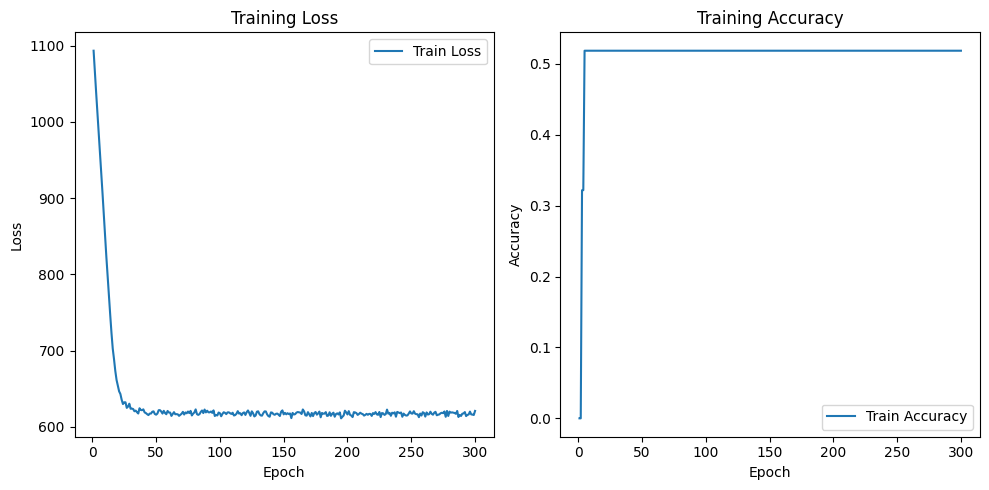

In [23]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, 300 + 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plotting the training accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, 300 + 1), train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
result = model.predict_proba(graph=data2.data.uns["CellFeatureGraph"])

In [27]:
#result = result[1970:]
result = torch.tensor(result)
predicted = torch.argmax(result, 1)
torch.set_printoptions(profile="full")
print(predicted)
correct = (predicted == y_test).sum().item()
total = y_test.numel()
accuracy = correct / total
print('accuracy: ', accuracy)

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,